<a href="https://colab.research.google.com/github/alperbayar14/ImageColorization/blob/main/Colaboratory'ye_Ho%C5%9F_Geldiniz_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("TPU adress:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU Connected!")
except ValueError:
    print("Tpu Connection problem")


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

base_dir = '/content/drive/MyDrive/Dataset/landscape_ımages/'
color_dir = os.path.join(base_dir, 'color')

def load_images_from_folder(folder, limit):
    images = []
    bw_images= []
    filenames = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= limit:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img = cv2.resize(img, (128, 128))

        if img is not None:
            img = (img.astype('float32'))/255.0
            img = 2 * img - 1
            lightness = ((img[:,:,0:1]))
            color = ((img[:, :, 1:]))

            images.append(color)
            bw_images.append(lightness)
            filenames.append(filename)
    return np.array(images),np.array(bw_images),filenames

sample_size = 2048

x_color, x_bw,filenames = load_images_from_folder(color_dir, sample_size)


x_test=x_color[1920:]
x_test_bw=x_bw[1920:]
x_train=x_color[:1920]
x_train_bw=x_bw[:1920]


In [ ]:
print(x_train.shape)
print(x_train_bw.shape)

(1920, 128, 128, 2)
(1920, 128, 128, 1)


In [ ]:
print("Lightness Kanalı (L):")
print("Min:", np.min(x_bw), "Max:", np.max(x_bw))

print("\nRenk Kanalları (AB):")
print("Min:", np.min(x_color), "Max:", np.max(x_color))

print("\nEğitim Verisi - Siyah Beyaz Kanal (x_train_bw):")
print("Min:", np.min(x_train_bw), "Max:", np.max(x_train_bw))

print("\nEğitim Verisi - Renk Kanalları (x_train):")
print("Min:", np.min(x_train), "Max:", np.max(x_train))


Lightness Kanalı (L):
Min: -1.0 Max: 1.0

Renk Kanalları (AB):
Min: -0.7411765 Max: 0.73333335

Eğitim Verisi - Siyah Beyaz Kanal (x_train_bw):
Min: -1.0 Max: 1.0

Eğitim Verisi - Renk Kanalları (x_train):
Min: -0.7411765 Max: 0.73333335


In [ ]:
import tensorflow as tf
x_train=tf.data.Dataset.from_tensor_slices(np.array(x_train[:1920])).batch(128)
x_train_bw=tf.data.Dataset.from_tensor_slices(np.array(x_train_bw[:1920])).batch(128)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense, Dropout, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_generator():
    inputs = Input(shape=(128, 128, 1))

    conv1 = Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = LeakyReLU()(conv1)

    conv2 = Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = LeakyReLU()(conv2)

    conv3 = Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = LeakyReLU()(conv3)

    bottleneck = Conv2D(128, kernel_size=(3, 3), strides=1, activation='tanh', padding='same')(conv3)
    concat_1 = Concatenate()([bottleneck, conv3])
    conv_up_3 = Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(concat_1)
    conv_up_3 = Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = Conv2DTranspose(64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat_2 = Concatenate()([conv_up_3, conv2])
    conv_up_2 = Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = Concatenate()([conv_up_2, conv1])
    conv_up_1 = Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)
    output = Conv2DTranspose(2, kernel_size=(5, 5), strides=1, activation='tanh')(conv_up_1)

    return Model(inputs, output)




In [ ]:
def build_discriminator():
    input_image = Input(shape=(128, 128, 2))
    condition = Input(shape=(128, 128, 1))

    combined_input = Concatenate()([condition, input_image])

    x = Conv2D(64, kernel_size=(4, 4), strides=2, padding='same')(combined_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)
    x = Conv2D(128, kernel_size=(4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.15)(x)
    x = Dropout(0.2)(x)
    output = Conv2D(256, kernel_size=(4, 4), strides=2, padding='same')(x)


    return Model([input_image, condition], output)


In [ ]:
with strategy.scope():
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.0004,
      decay_steps=80,
      decay_rate=0.8,
      staircase=True
  )
  class ExponentialIncrease(tf.keras.optimizers.schedules.LearningRateSchedule):
      def __init__(self, initial_learning_rate, growth_rate, growth_steps, staircase=False):
          self.initial_learning_rate = initial_learning_rate
          self.growth_rate = growth_rate
          self.growth_steps = growth_steps
          self.staircase = staircase

      def __call__(self, step):
          if self.staircase:
              return self.initial_learning_rate * (self.growth_rate ** (step // self.growth_steps))
          else:
              return self.initial_learning_rate * (self.growth_rate ** (step / self.growth_steps))

  lr_schedule_increasing = ExponentialIncrease(
      initial_learning_rate=0.0002,
      growth_rate=1.2,
      growth_steps=80,
      staircase=False
  )

In [ ]:
with strategy.scope():
  generator = build_generator()
  discriminator = build_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
mae_loss=tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM)


In [ ]:
with strategy.scope():

  adversarial_loss_funct=tf.keras.losses.BinaryCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.SUM)
  generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
  discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.999)



In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Model
with strategy.scope():
  def gen_pretrain_loss(generated_images,real_images):
    loss=mae_loss(real_images,generated_images)
    return loss

  def generator_loss(disc_generated_output, gen_output, target):
      adversarial_loss = adversarial_loss_funct(tf.ones_like(disc_generated_output), disc_generated_output)
      l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

      total_gen_loss = adversarial_loss + l1_loss*10000

      return total_gen_loss, adversarial_loss, l1_loss


  def discriminator_loss(disc_real_output, disc_generated_output):

      real_loss = adversarial_loss_funct(tf.ones_like(disc_real_output), disc_real_output)

      generated_loss = adversarial_loss_funct(tf.zeros_like(disc_generated_output), disc_generated_output)

      total_disc_loss = real_loss + generated_loss
      return total_disc_loss




In [ ]:
@tf.function
def train_step(bw_images, real_images):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(bw_images, training=True)

    disc_real_output = discriminator([bw_images, real_images], training=True)
    disc_generated_output = discriminator([bw_images, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, real_images)

    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  return gen_total_loss,disc_loss


@tf.function
def distributed_train_step(dataset_inputs):
    bw_images, real_images = dataset_inputs
    per_replica_gen_loss, per_replica_disc_loss = strategy.run(
        train_step, args=(bw_images, real_images,)
    )
    gen_loss = strategy.reduce(
        tf.distribute.ReduceOp.SUM, per_replica_gen_loss, axis=None
    )
    disc_loss = strategy.reduce(
        tf.distribute.ReduceOp.SUM, per_replica_disc_loss, axis=None
    )
    return gen_loss, disc_loss

In [ ]:
generator.compile(optimizer=generator_optimizer,loss='mae')

generator.fit(x_train_bw,x_train,128,25)

Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 168ms/step - loss: 0.0739
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0686
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0675
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0702
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0684
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0657
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0663
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0722
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0645
Epoch 10/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0646
Epoch 11/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0672
Epoch 12/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0700
Epoch 13/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0597
Epoch 14/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0662
Epoch 15/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - l

In [ ]:
train_ds = tf.data.Dataset.zip((x_train_bw, x_train))

import time
with strategy.scope():
  def fit(train_ds,epochs):
    for epoch in range(0,epochs):
      start = time.time()
      print("Epoch: ", epoch+1)
      for batch_number,dataset_inputs in enumerate(train_ds):
        gen_loss,disc_loss=distributed_train_step(dataset_inputs)
        print(f"Batch {batch_number + 1}: Generator Loss = {gen_loss:.4f}, Discriminator Loss = {disc_loss:.4f}")
      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

In [ ]:
fit(train_ds, epochs=10)

Epoch:  1
Batch 1: Generator Loss = 188034.8906, Discriminator Loss = 364885.7500
Batch 2: Generator Loss = 188058.2344, Discriminator Loss = 364400.5312
Batch 3: Generator Loss = 187777.6562, Discriminator Loss = 364107.5625
Batch 4: Generator Loss = 188076.6875, Discriminator Loss = 364513.0312
Batch 5: Generator Loss = 187821.8906, Discriminator Loss = 364739.5000
Batch 6: Generator Loss = 187906.0938, Discriminator Loss = 364360.9688
Batch 7: Generator Loss = 188114.0312, Discriminator Loss = 364343.3750
Batch 8: Generator Loss = 188244.1406, Discriminator Loss = 364857.9688
Batch 9: Generator Loss = 187956.9062, Discriminator Loss = 364575.4375
Batch 10: Generator Loss = 187786.6875, Discriminator Loss = 364104.5312
Batch 11: Generator Loss = 187828.1406, Discriminator Loss = 364402.2500
Batch 12: Generator Loss = 187712.7500, Discriminator Loss = 364790.1250
Batch 13: Generator Loss = 188092.0156, Discriminator Loss = 364523.7812
Batch 14: Generator Loss = 188023.3906, Discrimina

In [ ]:
generator.save('/content/drive/MyDrive/Dataset/landscape_ımages/generator_finished_35.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
(1, 128, 128, 2)
(128, 128, 3)


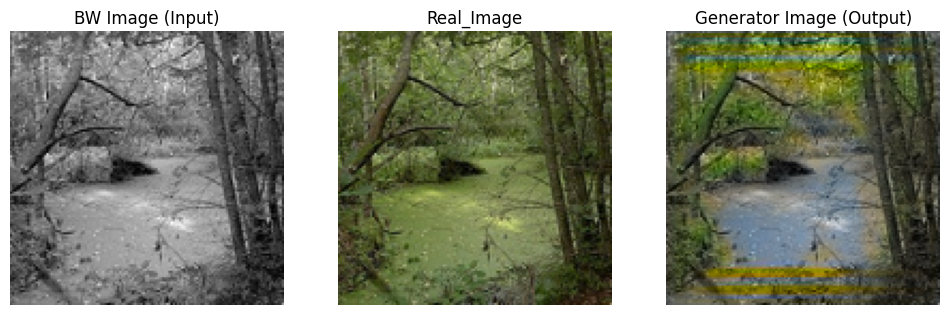

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bw_image = x_test_bw[22:23]
color_image = x_test[22:23]
def get_image_and_grayscale(bw_image,color_image):
    output_image = np.zeros((128,128,3))
    output_image[:,:,:1] = ((bw_image+1)*255)/2
    output_image[:,:,1:] = (((color_image+1))*255)/2
    output_image = np.uint8(output_image)

    output_image = cv2.cvtColor(output_image,cv2.COLOR_Lab2BGR)
    output_image = cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB)

    return output_image

generated_image = generator.predict(bw_image)
print(color_image.shape)
generated_image=get_image_and_grayscale(bw_image[0],generated_image[0])
real_image=get_image_and_grayscale(bw_image[0],color_image[0])
print(generated_image.shape)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(bw_image), cmap="gray")
plt.title("BW Image (Input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(real_image)
plt.title("Real_Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title("Generator Image (Output)")
plt.axis("off")

plt.show()
